In [2]:
import boto3
import botocore
import sagemaker
import sys


bucket = (
    sagemaker.Session().default_bucket()
)  # Feel free to change to another bucket you have access to
prefix = "sagemaker/rcf-benchmarks"
execution_role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket where the original data is downloaded and stored.
downloaded_data_bucket = f"explainable-ai-stall"
downloaded_data_prefix = "SimulatedData"


def check_bucket_permission(bucket):
    # check if the bucket exists
    permission = False
    try:
        boto3.Session().client("s3").head_bucket(Bucket=bucket)
    except botocore.exceptions.ParamValidationError as e:
        print(
            "Hey! You either forgot to specify your S3 bucket"
            " or you gave your bucket an invalid name!"
        )
    except botocore.exceptions.ClientError as e:
        if e.response["Error"]["Code"] == "403":
            print(f"Hey! You don't have permission to access the bucket, {bucket}.")
        elif e.response["Error"]["Code"] == "404":
            print(f"Hey! Your bucket, {bucket}, doesn't exist!")
        else:
            raise
    else:
        permission = True
    return permission


if check_bucket_permission(bucket):
    print(f"Training input/output will be stored in: s3://{bucket}/{prefix}")
if check_bucket_permission(downloaded_data_bucket):
    print(
        f"Downloaded training data will be read from s3://{downloaded_data_bucket}/{downloaded_data_prefix}"
    )

Training input/output will be stored in: s3://sagemaker-us-east-1-293556221747/sagemaker/rcf-benchmarks
Downloaded training data will be read from s3://explainable-ai-stall/SimulatedData


In [3]:
%%time

import pandas as pd

data_filename = "Stall_Data_71521.csv"
s3 = boto3.client("s3")
s3.download_file(downloaded_data_bucket, f"{downloaded_data_prefix}/{data_filename}", data_filename)
flight_data = pd.read_csv(data_filename, delimiter=",")

CPU times: user 192 ms, sys: 20.2 ms, total: 212 ms
Wall time: 380 ms


Before training any models it is important to inspect our data, first. Perhaps there are some underlying patterns or structures that we could provide as "hints" to the model or maybe there is some noise that we could pre-process away. The raw data looks like this:

In [8]:
flight_data.head()

,Unnamed: 0,flight_id,initial_alt,time_to_buffet,time_from_buffet_to_uncommanded_descent,magnitude_of_uncommanded_descent,time_from_buffet_to_uncommanded_roll,magnitude_of_uncommanded_roll,period_of_uncommanded_roll,initial_airspeed,...,cur_airspeed,cur_avg_airspeed,roll,vertical_speed,cur_avg_vertical_speed,angle_of_attack,flight_path_angle,cur_avg_flight_path_angle,pitch_angle,sign_flag
0,0,0,31599,999,4,27,34,3,-4.94891,148,...,148.000000,148.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,1
1,1,0,31599,999,4,27,34,3,-4.94891,148,...,146.185648,147.092824,0.0,4.66801,2.334005,0.0,1.830019,0.909250,1.830019,1
2,2,0,31599,999,4,27,34,3,-4.94891,148,...,146.931906,147.039185,0.0,14.25792,6.308643,0.0,5.569018,2.459183,5.569018,1
3,3,0,31599,999,4,27,34,3,-4.94891,148,...,149.887561,147.751279,0.0,-11.33209,1.898460,0.0,-4.336243,0.736269,-4.336243,1
4,4,0,31599,999,4,27,34,3,-4.94891,148,...,140.303439,146.261711,0.0,54.08289,12.335346,0.0,22.674646,4.838286,22.674646,1


In [9]:
flight_data.tail()

,Unnamed: 0,flight_id,initial_alt,time_to_buffet,time_from_buffet_to_uncommanded_descent,magnitude_of_uncommanded_descent,time_from_buffet_to_uncommanded_roll,magnitude_of_uncommanded_roll,period_of_uncommanded_roll,initial_airspeed,...,cur_airspeed,cur_avg_airspeed,roll,vertical_speed,cur_avg_vertical_speed,angle_of_attack,flight_path_angle,cur_avg_flight_path_angle,pitch_angle,sign_flag
10655,10655,0,31599,999,4,27,34,-31,-4.94891,148,...,-314.0,364.611764,-0.529919,-860.43854,-778.097411,29.0,-90.00663,-90.00663,-61.00663,1
10656,10656,0,31599,999,4,27,34,-30,-4.94891,148,...,-315.0,365.243848,-0.515038,-798.24171,-779.627645,29.0,-90.00663,-90.00663,-61.00663,1
10657,10657,0,31599,999,4,27,34,-29,-4.94891,148,...,-316.0,366.813377,-0.500000,-730.20381,-781.486475,29.0,-90.00663,-90.00663,-61.00663,1
10658,10658,0,31599,999,4,27,34,-28,-4.94891,148,...,-317.0,368.415786,-0.484810,-756.84723,-782.519408,29.0,-90.00663,-90.00663,-61.00663,1
10659,10659,0,31599,999,4,27,34,-27,-4.94891,148,...,-318.0,369.228150,-0.469472,-725.85511,-779.806943,29.0,-90.00663,-90.00663,-61.00663,1


Plot the initial visualizations of our variables.

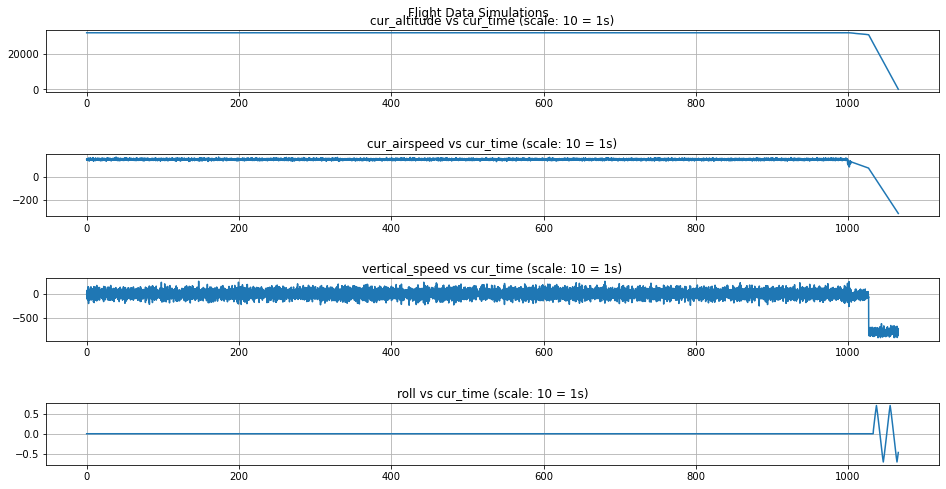

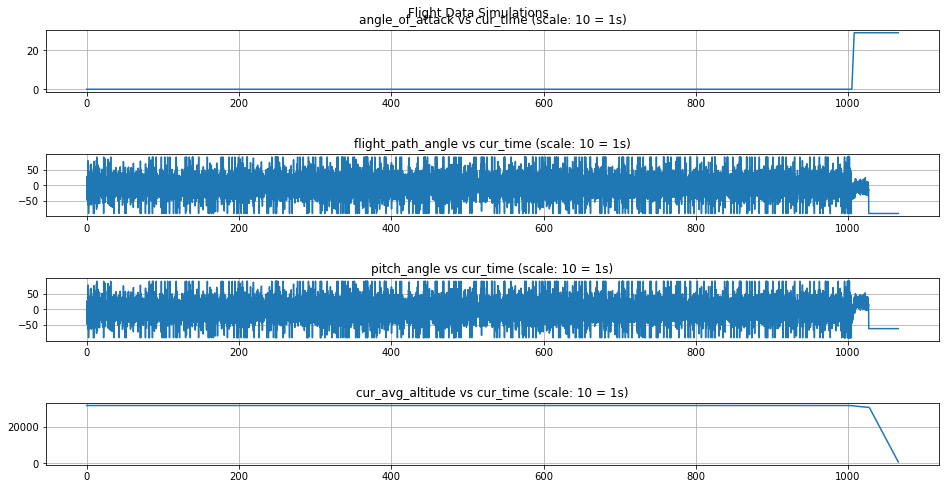

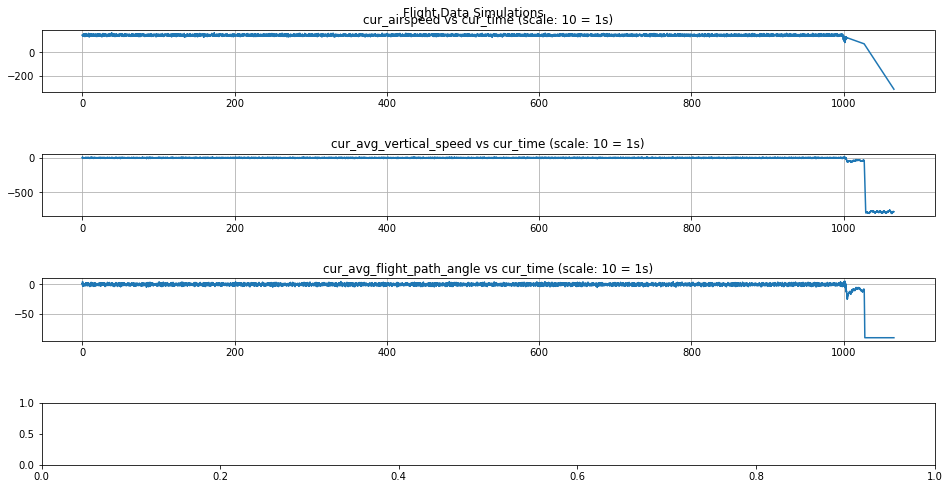

In [56]:
# %matplotlib inline

# import matplotlib
# import matplotlib.pyplot as plt

# matplotlib.rcParams["figure.dpi"] = 100

# flight_data.plot("vertical_speed")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def lineplots_flight_data(cols, time, df, n):
    fig, axs = plt.subplots(nrows, 1, figsize=(16, 8))
    for col, ax in zip(cols, axs.flatten()):
        ax.grid()
        ax.plot(time, df[col])
        ax.set_title(col + ' vs ' + time.name + ' (scale: 10 = 1s)')
        #ax.set_xticks(np.arange(min(time), max(time) + 10, 10.0))
    plt.subplots_adjust(hspace=1, wspace=0.1)
    fig.suptitle('Flight Data Simulations', y=0.92)
#     fig.savefig(cwd + '/visuals/' + 'flight_data' + str(n) + '.png')
    plt.show()
    plt.close()


if __name__ == '__main__':
    df = flight_data
    cols = ['cur_altitude', 'cur_airspeed', 'vertical_speed', 'roll', 'angle_of_attack', 'flight_path_angle', 'pitch_angle',
            'cur_avg_altitude', 'cur_airspeed', 'cur_avg_vertical_speed', 'cur_avg_flight_path_angle']
    time = df['cur_time']
    nrows = 4  # How many figures you want in a single plot
    # Using list comprehension (https://www.geeksforgeeks.org/break-list-chunks-size-n-python/) to break up cols list into chunks based on nrows
    split_cols = [cols[i * nrows:(i + 1) * nrows] for i in range((len(cols) + nrows - 1) // nrows)]
    for n in range(len(split_cols)):
        lineplots_flight_data(split_cols[n], time, df, n)

## Hyperparameters

Particular to a SageMaker RCF training job are the following hyperparameters:

* **`num_samples_per_tree`** - the number randomly sampled data points sent to each tree. As a general rule, `1/num_samples_per_tree` should approximate the the estimated ratio of anomalies to normal points in the dataset.
* **`num_trees`** - the number of trees to create in the forest. Each tree learns a separate model from different samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.
* **`feature_dim`** - the dimension of each data point.

After testing different hyperparameters we found that, with a m4.xlarge instance, 512 samples per tree and 500 trees gave us the best results at the lowest processing cost.

In [13]:
### https://sagemaker.readthedocs.io/en/stable/overview.html#sagemaker-automatic-model-tuning ###

from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(
    role=execution_role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix}/",
    output_path=f"s3://{bucket}/{prefix}/output",
    num_samples_per_tree=512,
    num_trees=500,
)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(flight_data.to_numpy()))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-07-15 12:24:49 Starting - Starting the training job...
2021-07-15 12:25:12 Starting - Launching requested ML instancesProfilerReport-1626351889: InProgress
......
2021-07-15 12:26:12 Starting - Preparing the instances for training.........
2021-07-15 12:27:46 Downloading - Downloading input data...
2021-07-15 12:28:13 Training - Downloading the training image...
2021-07-15 12:28:50 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/15/2021 12:28:55 INFO 140682480236352] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric

[07/15/2021 12:28:56 INFO 140682480236352] Cluster sharing facilities started.
[07/15/2021 12:28:56 INFO 140682480236352] Verifying all workers are accessible...
[07/15/2021 12:28:56 INFO 140682480236352] All workers accessible.
[07/15/2021 12:28:56 INFO 140682480236352] Initializing Sampler...
[07/15/2021 12:28:56 INFO 140682480236352] Sampler correctly initialized.
#metrics {"StartTime": 1626352135.484741, "EndTime": 1626352136.808781, "Dimensions": {"Algorithm": "RandomCutForest", "Host": "algo-1", "Operation": "training"}, "Metrics": {"initialize.time": {"sum": 1318.1931972503662, "count": 1, "min": 1318.1931972503662, "max": 1318.1931972503662}}}

#metrics {"StartTime": 1626352136.8089812, "EndTime": 1626352136.809039, "Dimensions": {"Algorithm": "RandomCutForest", "Host": "algo-1", "Operation": "training", "Meta": "init_train_data_iter"}, "Metrics": {"Total Records Seen": {"sum": 0.0, "count": 1, "min": 0, "max": 0}, "Total Batches Seen": {"sum": 0.0, "count": 1, "min": 0, "max":


2021-07-15 12:29:13 Uploading - Uploading generated training model
2021-07-15 12:29:13 Completed - Training job completed
Training seconds: 84
Billable seconds: 84


In [14]:
print(f"Training job name: {rcf.latest_training_job.job_name}")

Training job name: randomcutforest-2021-07-15-12-24-49-363


# Inference

***

Our trained Random Cut Forest model does nothing on its own. We now want to use the model we computed to perform inference on data. In this case, it means computing anomaly scores from input time series flight variable data points.

We create an inference endpoint using the SageMaker Python SDK `deploy()` function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up. We used a m4.xlarge instance for this pmodel. AWS recommends using the `ml.c5` instance type as it provides the fastest inference time at the lowest cost, however, we were unable to gain permissions to run this instance type for this project.

In [15]:
rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-------------------!

In [16]:
print(f"Endpoint name: {rcf_inference.endpoint}")

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: randomcutforest-2021-07-15-12-29-32-078


Next we pass the training dataset, in CSV format, to the inference endpoint so we can automatically detect the anomalies we saw with our eyes in the plots, above.

We added the JSON deserislizer here as well. Future work may want to use JSON data instead of CSV files.

In [17]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

flight_data_numpy = flight_data.to_numpy()
print(flight_data_numpy[:2])
results = rcf_inference.predict(
    flight_data_numpy[:2], initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

[[ 0.00000000e+00  0.00000000e+00  3.15990000e+04  9.99000000e+02
   4.00000000e+00  2.70000000e+01  3.40000000e+01  3.00000000e+00
  -4.94891000e+00  1.48000000e+02  2.80000000e+01  4.69000000e+02
   6.00000000e+00  2.90000000e+01  9.55949145e-01  0.00000000e+00
  -1.94406500e+00 -2.64032120e+01  1.76139200e+00 -1.03402660e+01
   3.15990000e+04  3.15990000e+04  1.48000000e+02  1.48000000e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00  3.15990000e+04  9.99000000e+02
   4.00000000e+00  2.70000000e+01  3.40000000e+01  3.00000000e+00
  -4.94891000e+00  1.48000000e+02  2.80000000e+01  4.69000000e+02
   6.00000000e+00  2.90000000e+01  9.55949145e-01  1.00000000e-01
   4.66801000e-01 -3.14329570e+01 -1.81435200e+00 -7.35947900e+00
   3.15994668e+04  3.15992334e+04  1.46185648e+02  1.47092824e+02
   0.00000000e+00  4.66801000e+00  2.33400500e+00  0.00000000e+00
   1.8300

## Computing Anomaly Scores

Now, let's compute and plot the anomaly scores for cur_avg_altitude, cur_avg_airspeed, cur_avg_vertical_speed, cur_avg_flight_path_angle, and roll.

In [18]:
results = rcf_inference.predict(flight_data_numpy)
scores = [datum["score"] for datum in results["scores"]]

# add scores to flight data frame and print first few values
flight_data["score"] = pd.Series(scores, index=flight_data.index)
flight_data.head()

,Unnamed: 0,flight_id,initial_alt,time_to_buffet,time_from_buffet_to_uncommanded_descent,magnitude_of_uncommanded_descent,time_from_buffet_to_uncommanded_roll,magnitude_of_uncommanded_roll,period_of_uncommanded_roll,initial_airspeed,...,cur_avg_airspeed,roll,vertical_speed,cur_avg_vertical_speed,angle_of_attack,flight_path_angle,cur_avg_flight_path_angle,pitch_angle,sign_flag,score
0,0,0,31599,999,4,27,34,3,-4.94891,148,...,148.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,1,3.950221
1,1,0,31599,999,4,27,34,3,-4.94891,148,...,147.092824,0.0,4.66801,2.334005,0.0,1.830019,0.909250,1.830019,1,3.948971
2,2,0,31599,999,4,27,34,3,-4.94891,148,...,147.039185,0.0,14.25792,6.308643,0.0,5.569018,2.459183,5.569018,1,3.945392
3,3,0,31599,999,4,27,34,3,-4.94891,148,...,147.751279,0.0,-11.33209,1.898460,0.0,-4.336243,0.736269,-4.336243,1,3.944003
4,4,0,31599,999,4,27,34,3,-4.94891,148,...,146.261711,0.0,54.08289,12.335346,0.0,22.674646,4.838286,22.674646,1,3.950351


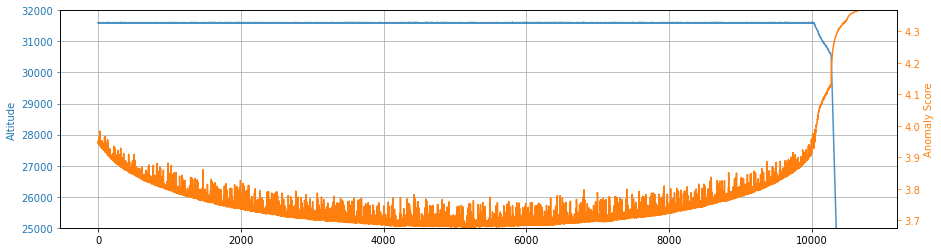

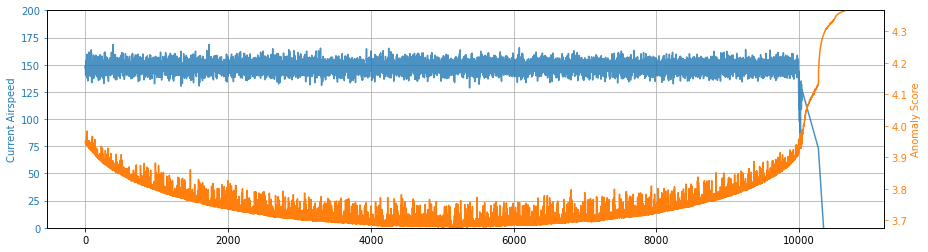

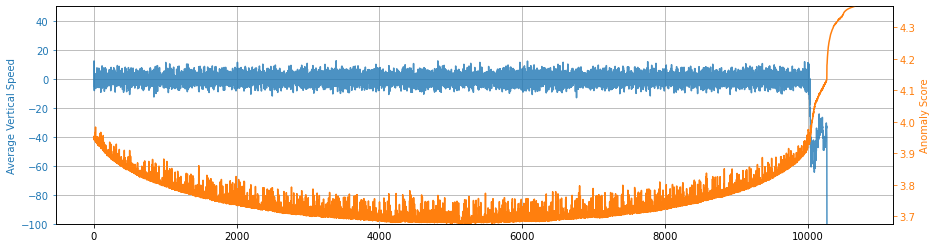

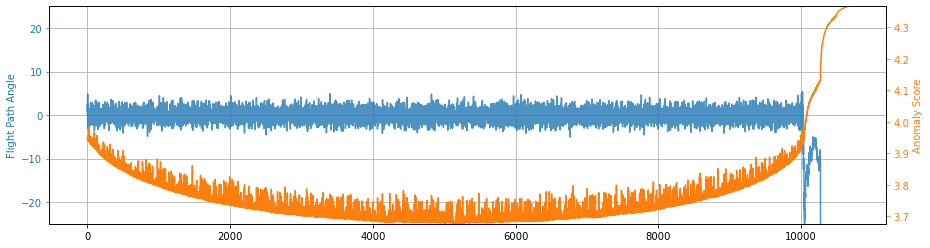

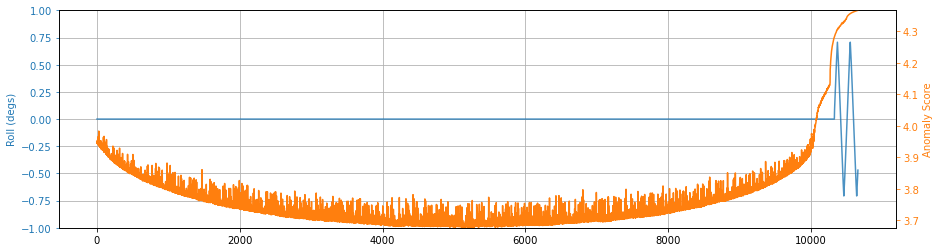

In [29]:
# cur_altitude, to find onset of uncommanded descent
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
start, end = 0, len(flight_data)
flight_data_subset = flight_data[start:end]
ax1.plot(flight_data_subset["cur_altitude"], color="C0", alpha=0.8)
ax2.plot(flight_data_subset["score"], color="C1")
ax1.grid(which="major", axis="both")
ax1.set_ylabel("Altitude", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(25000,32000)
ax2.set_ylim(min(scores), max(scores))
fig.set_figwidth(15)

# cur_airspeed, to find onset of uncommanded descent/stall 
#### (as plane tries to accelorate to avoid stall?) ####
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
start, end = 0, len(flight_data)
flight_data_subset = flight_data[start:end]
ax1.plot(flight_data_subset["cur_airspeed"], color="C0", alpha=0.8)
ax2.plot(flight_data_subset["score"], color="C1")
ax1.grid(which="major", axis="both")
ax1.set_ylabel("Current Airspeed", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(0,200)
ax2.set_ylim(min(scores), max(scores))
fig.set_figwidth(15)

# cur_avg_vertical_speed, to find onset of uncommanded descent/stall 
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
start, end = 0, len(flight_data)
flight_data_subset = flight_data[start:end]
ax1.plot(flight_data_subset["cur_avg_vertical_speed"], color="C0", alpha=0.8)
ax2.plot(flight_data_subset["score"], color="C1")
ax1.grid(which="major", axis="both")
ax1.set_ylabel("Average Vertical Speed", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(-100,50)
ax2.set_ylim(min(scores), max(scores))
fig.set_figwidth(15)

# flight_path_angle, stall indicator
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
start, end = 0, len(flight_data)
flight_data_subset = flight_data[start:end]
ax1.plot(flight_data_subset["cur_avg_flight_path_angle"], color="C0", alpha=0.8)
ax2.plot(flight_data_subset["score"], color="C1")
ax1.grid(which="major", axis="both")
ax1.set_ylabel("Flight Path Angle", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(-25,25)
ax2.set_ylim(min(scores), max(scores))
fig.set_figwidth(15)

# roll, to find onset of uncommanded roll
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
start, end = 0, len(flight_data)
flight_data_subset = flight_data[start:end]
ax1.plot(flight_data_subset["roll"], color="C0", alpha=0.8)
ax2.plot(flight_data_subset["score"], color="C1")
ax1.grid(which="major", axis="both")
ax1.set_ylabel("Roll (degs)", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(-1,1)
ax2.set_ylim(min(scores), max(scores))
fig.set_figwidth(15)

Note that the anomaly score spikes where our eyeball-norm method suggests there is an anomalous data point as well as in some places where our eyeballs are not as accurate.

Below we print and plot any data points with scores greater than 2 standard deviations (approx 95th percentile) from the mean score.

In [30]:
score_mean = flight_data["score"].mean()
score_std = flight_data["score"].std()
print(f"Mean of all Scores: ",score_mean)
print(f"Standard Deviation of all Scores: ",score_std)
score_cutoff = score_mean + 2 * score_std

anomalies = flight_data_subset[flight_data_subset["score"] > score_cutoff]
anomalies

Mean of all Scores:  3.7757273735925043
Standard Deviation of all Scores:  0.13193947700495806


,Unnamed: 0,flight_id,initial_alt,time_to_buffet,time_from_buffet_to_uncommanded_descent,magnitude_of_uncommanded_descent,time_from_buffet_to_uncommanded_roll,magnitude_of_uncommanded_roll,period_of_uncommanded_roll,initial_airspeed,...,cur_avg_airspeed,roll,vertical_speed,cur_avg_vertical_speed,angle_of_attack,flight_path_angle,cur_avg_flight_path_angle,pitch_angle,sign_flag,score
10089,10089,0,31599,999,4,27,34,3,-4.94891,148,...,218.021971,0.000000,-141.41061,-56.424359,29.0,-37.497512,-15.000049,-8.497512,1,4.041296
10090,10090,0,31599,999,4,27,34,3,-4.94891,148,...,219.527744,0.000000,-112.61548,-61.765971,29.0,-27.502920,-16.342498,1.497080,1,4.041183
10092,10092,0,31599,999,4,27,34,3,-4.94891,148,...,223.942776,0.000000,-66.39702,-61.350211,29.0,-15.209086,-15.900911,13.790914,1,4.041091
10093,10093,0,31599,999,4,27,34,3,-4.94891,148,...,226.010109,0.000000,7.80840,-58.723019,29.0,1.778003,-15.060773,30.778003,1,4.042044
10094,10094,0,31599,999,4,27,34,3,-4.94891,148,...,229.179517,0.000000,-95.66909,-64.392319,29.0,-21.375191,-16.319243,7.624809,1,4.045057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10655,10655,0,31599,999,4,27,34,-31,-4.94891,148,...,364.611764,-0.529919,-860.43854,-778.097411,29.0,-90.006630,-90.006630,-61.006630,1,4.365832
10656,10656,0,31599,999,4,27,34,-30,-4.94891,148,...,365.243848,-0.515038,-798.24171,-779.627645,29.0,-90.006630,-90.006630,-61.006630,1,4.365880
10657,10657,0,31599,999,4,27,34,-29,-4.94891,148,...,366.813377,-0.500000,-730.20381,-781.486475,29.0,-90.006630,-90.006630,-61.006630,1,4.365925
10658,10658,0,31599,999,4,27,34,-28,-4.94891,148,...,368.415786,-0.484810,-756.84723,-782.519408,29.0,-90.006630,-90.006630,-61.006630,1,4.365999


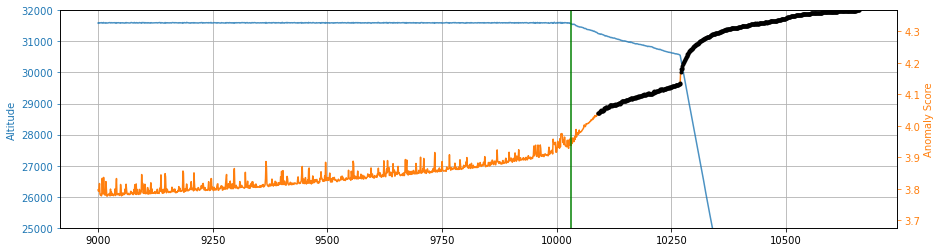

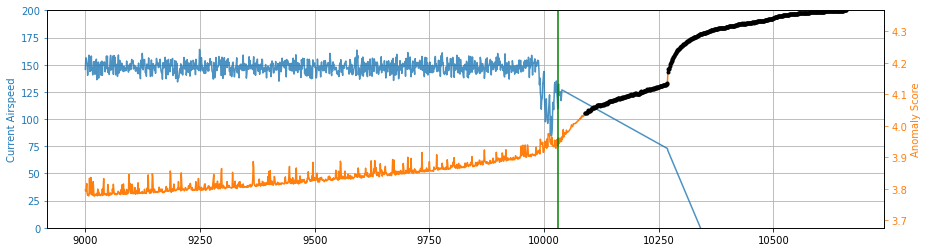

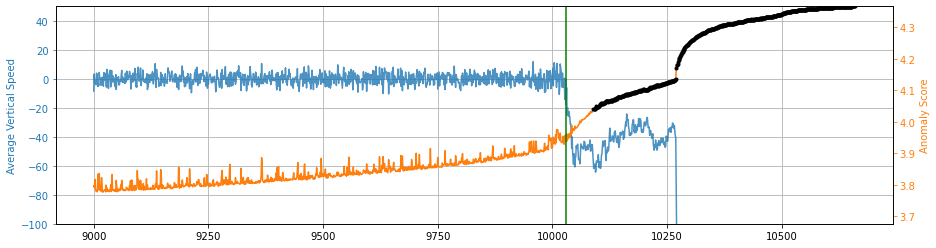

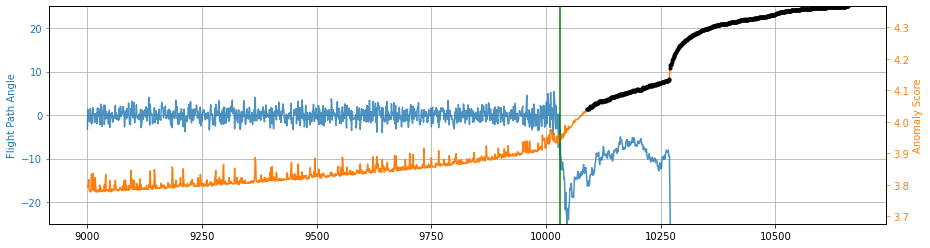

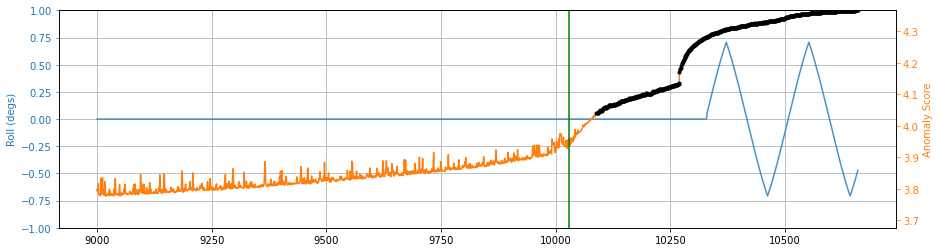

In [31]:
# cur_altitude, to find onset of uncommanded descent
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
start, end = 9000, len(flight_data)
flight_data_subset = flight_data[start:end]
ax1.plot(flight_data_subset["cur_altitude"], color="C0", alpha=0.8)
ax2.plot(flight_data_subset["score"], color="C1")
ax1.grid(which="major", axis="both")
ax1.set_ylabel("Altitude", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(25000,32000)
ax2.set_ylim(min(scores), max(scores))
fig.set_figwidth(15)
ax2.plot(anomalies.index, anomalies.score, "ko", markersize=3)
plt.axvline(x=10030, color='g', label='avline')

# cur_airspeed, to find onset of uncommanded descent/stall 
#### (as plane tries to accelorate to avoid stall?) ####
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
start, end = 9000, len(flight_data)
flight_data_subset = flight_data[start:end]
ax1.plot(flight_data_subset["cur_airspeed"], color="C0", alpha=0.8)
ax2.plot(flight_data_subset["score"], color="C1")
ax1.grid(which="major", axis="both")
ax1.set_ylabel("Current Airspeed", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(0,200)
ax2.set_ylim(min(scores), max(scores))
fig.set_figwidth(15)
ax2.plot(anomalies.index, anomalies.score, "ko", markersize=3)
plt.axvline(x=10030, color='g', label='avline')

# cur_avg_vertical_speed, to find onset of uncommanded descent/stall 
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
start, end = 9000, len(flight_data)
flight_data_subset = flight_data[start:end]
ax1.plot(flight_data_subset["cur_avg_vertical_speed"], color="C0", alpha=0.8)
ax2.plot(flight_data_subset["score"], color="C1")
ax1.grid(which="major", axis="both")
ax1.set_ylabel("Average Vertical Speed", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(-100,50)
ax2.set_ylim(min(scores), max(scores))
fig.set_figwidth(15)
ax2.plot(anomalies.index, anomalies.score, "ko", markersize=3)
plt.axvline(x=10030, color='g', label='avline')

# flight_path_angle, stall indicator
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
start, end = 9000, len(flight_data)
flight_data_subset = flight_data[start:end]
ax1.plot(flight_data_subset["cur_avg_flight_path_angle"], color="C0", alpha=0.8)
ax2.plot(flight_data_subset["score"], color="C1")
ax1.grid(which="major", axis="both")
ax1.set_ylabel("Flight Path Angle", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(-25,25)
ax2.set_ylim(min(scores), max(scores))
fig.set_figwidth(15)
ax2.plot(anomalies.index, anomalies.score, "ko", markersize=3)
plt.axvline(x=10030, color='g', label='avline')

# roll, to find onset of uncommanded roll
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
start, end = 9000, len(flight_data)
flight_data_subset = flight_data[start:end]
ax1.plot(flight_data_subset["roll"], color="C0", alpha=0.8)
ax2.plot(flight_data_subset["score"], color="C1")
ax1.grid(which="major", axis="both")
ax1.set_ylabel("Roll (degs)", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(-1,1)
ax2.set_ylim(min(scores), max(scores))
fig.set_figwidth(15)
ax2.plot(anomalies.index, anomalies.score, "ko", markersize=3)
plt.axvline(x=10030, color='g', label='avline')

With the current hyperparameter choices we see that the two-standard-deviation threshold, while able to capture the known anomalies as well as the ones apparent in the ridership plot, is rather sensitive to fine-grained peruturbations and anomalous behavior. Adding trees to the SageMaker RCF model could smooth out the results as well as using a larger data set.

## Stop and Delete the Endpoint

Finally, we should delete the endpoint before we close the notebook.

To do so execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable `endpoint_name`, and select "Delete" from the "Actions" dropdown menu. 

In [32]:
# What is the updatded code needed?
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


# Epilogue

---

We used Amazon SageMaker Random Cut Forest to detect anomalous datapoints in the flight dataset. In this data, the anomalies occurred when the dependant variables were uncharacteristically high or low. However, the RCF algorithm is also capable of detecting when, for example, data breaks periodicity or uncharacteristically changes global behavior.

There are several ways to improve algorithm performance. One method, for example, is to use an appropriate training set. If we know that a particular set of data is characteristic of "normal" flight behavior, then training on said set of data will more accurately characterize "abnormal" flight data.

Another improvement is make use of a windowing technique called "shingling". This is especially useful when working with periodic data with a known time period.. The idea is to treat a period of $P$ datapoints as a single datapoint of feature length $P$ and then run the RCF algorithm on these feature vectors. That is, if our original data consists of points $x_1, x_2, \ldots, x_N \in \mathbb{R}$ then we perform the transformation,

```
data = [[x_1],            shingled_data = [[x_1, x_2, ..., x_{P}],
        [x_2],    --->                     [x_2, x_3, ..., x_{P+1}],
        ...                                ...
        [x_N]]                             [x_{N-P}, ..., x_{N}]]

```

In [4]:
import numpy as np


def shingle(data, shingle_size):
    num_data = len(data)
    shingled_data = np.zeros((num_data - shingle_size, shingle_size))

    for n in range(num_data - shingle_size):
        shingled_data[n] = data[n : (n + shingle_size)]
    return shingled_data


# single data with shingle size = 10 (one second)
shingle_size = 10
prefix_shingled = "sagemaker/randomcutforest_shingled"
flight_data_shingled = shingle(flight_data.values[:,26], shingle_size)
print(flight_data_shingled)

[[ 0.00000000e+00  2.33400500e+00  6.30864333e+00 ...  4.97757500e+00
  -8.09125111e+00 -2.55510800e+00]
 [ 2.33400500e+00  6.30864333e+00  1.89846000e+00 ... -8.09125111e+00
  -2.55510800e+00  3.28489636e+00]
 [ 6.30864333e+00  1.89846000e+00  1.23353460e+01 ... -2.55510800e+00
   3.28489636e+00  2.47599167e-01]
 ...
 [-7.89288824e+02 -7.81751801e+02 -7.80571101e+02 ... -7.77259668e+02
  -7.78097411e+02 -7.79627645e+02]
 [-7.81751801e+02 -7.80571101e+02 -7.77712094e+02 ... -7.78097411e+02
  -7.79627645e+02 -7.81486475e+02]
 [-7.80571101e+02 -7.77712094e+02 -7.78153316e+02 ... -7.79627645e+02
  -7.81486475e+02 -7.82519408e+02]]


We create a new training job and and inference endpoint. (Note that we cannot re-use the endpoint created above because it was trained with one-dimensional data.)

In [6]:
session = sagemaker.Session()
from sagemaker import RandomCutForest

# specify general training job information
rcf = RandomCutForest(
    role=execution_role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix_shingled}/",
    output_path=f"s3://{bucket}/{prefix_shingled}/output",
    num_samples_per_tree=512,
    num_trees=500,
)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(flight_data_shingled))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-07-23 12:45:29 Starting - Starting the training job...
2021-07-23 12:45:52 Starting - Launching requested ML instancesProfilerReport-1627044329: InProgress
...
2021-07-23 12:46:26 Starting - Preparing the instances for training.........
2021-07-23 12:47:55 Downloading - Downloading input data...
2021-07-23 12:48:13 Training - Downloading the training image...
2021-07-23 12:48:54 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/23/2021 12:48:58 INFO 140672260732736] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '


2021-07-23 12:49:13 Uploading - Uploading generated training model
2021-07-23 12:49:13 Completed - Training job completed
Training seconds: 78
Billable seconds: 78


In [7]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-------------------!

In [8]:
print(rcf_inference.content_type, rcf_inference.accept)

text/csv ('application/json',)


Using the above inference endpoint we compute the anomaly scores associated with the shingled data.

In [59]:
# Score the shingled datapoints
results = rcf_inference.predict(
    flight_data_shingled, initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)
scores = np.array([datum["score"] for datum in results["scores"]])

# compute the shingled score distribution and cutoff and determine anomalous scores
score_mean = scores.mean()
score_std = scores.std()
score_cutoff = score_mean + 2 * score_std

anomalies = scores[scores > score_cutoff]
anomaly_indices = np.arange(len(scores))[scores > score_cutoff]

print(f"Mean of shingled Scores: ",score_mean)
print(f"Standard Deviation of shingled Scores: ",score_std)
anomalies

Mean of shingled Scores:  1.2170849553962908
Standard Deviation of shingled Scores:  0.7247469153039261


array([2.66808698, 2.84713067, 2.9805975 , 3.0454343 , 3.14456127,
       3.2613306 , 3.31179554, 3.41099127, 3.47600088, 3.52589783,
       3.57963481, 3.63442691, 3.69247129, 3.72640226, 3.76486823,
       3.79966442, 3.82084499, 3.8361992 , 3.83351375, 3.84031979,
       3.83774559, 3.82791727, 3.81663542, 3.82084277, 3.81960847,
       3.81326379, 3.81769013, 3.8167327 , 3.81626258, 3.81417341,
       3.81386522, 3.81510778, 3.8112999 , 3.80250662, 3.79400218,
       3.77908502, 3.75917592, 3.74739585, 3.75608318, 3.75948582,
       3.75865949, 3.75965228, 3.76255088, 3.75845712, 3.75905805,
       3.76017717, 3.76509368, 3.76635645, 3.75724004, 3.75856065,
       3.76246532, 3.75971338, 3.75462976, 3.7563473 , 3.75822865,
       3.77251287, 3.79305381, 3.81288663, 3.83324826, 3.84321924,
       3.85813158, 3.87345572, 3.88266172, 3.8921478 , 3.89652946,
       3.89791479, 3.88992862, 3.8863546 , 3.88611532, 3.88530659,
       3.87997372, 3.87847239, 3.8797217 , 3.87478529, 3.86969

Finally, we plot the scores from the shingled data on top of the original dataset and mark the score lying above the anomaly score threshold.

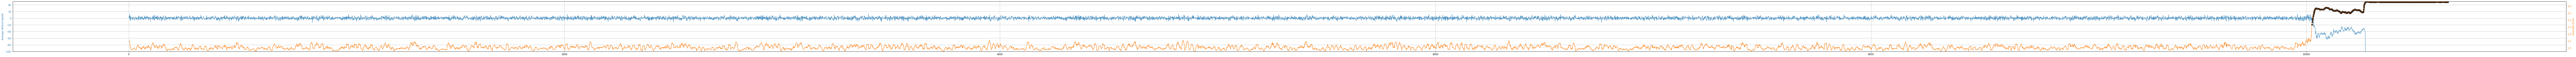

In [55]:
# cur_avg_vertical_speed, to find onset of uncommanded descent/stall 
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
start, end = 0, len(flight_data)
flight_data_subset = flight_data[start:end]

ax1.plot(flight_data_subset["cur_avg_vertical_speed"], color="C0", alpha=0.8)
ax2.plot(scores, color="C1")
ax2.scatter(anomaly_indices, anomalies, color="k")

ax1.grid(which="major", axis="both")
ax1.set_ylabel("Average Vertical Speed", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(-100,50)
ax2.set_ylim(min(scores), max(scores))
fig.set_figwidth(200)
plt.show()

In [60]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
